In [0]:
from fastai.text import *

In [0]:
!wget https://github.com/wshuyi/public_datasets/raw/master/dianping.csv

--2019-09-02 12:36:56--  https://github.com/wshuyi/public_datasets/raw/master/dianping.csv
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/wshuyi/public_datasets/master/dianping.csv [following]
--2019-09-02 12:36:57--  https://raw.githubusercontent.com/wshuyi/public_datasets/master/dianping.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 531037 (519K) [text/plain]
Saving to: ‘dianping.csv’

dianping.csv        100%[===================>] 518.59K  --.-KB/s    in 0.06s   

2019-09-02 12:36:57 (7.95 MB/s) - ‘dianping.csv’ saved [531037/531037]



In [0]:
df = pd.read_csv("dianping.csv")

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
train, test = train_test_split(df, test_size=.2, random_state=2)

In [0]:
train, valid = train_test_split(train, test_size=.2, random_state=2)

In [0]:
len(train)

1280

In [0]:
len(valid)

320

In [0]:
len(test)

400

In [0]:
train.head()

,comment,sentiment
330,跟老公去大悦城玩儿的时候吃的，味道真的还不错哦！这家店是一对年轻的小两口自主创业开的店，环境...,1
1326,味道是好，但是真的很生气，排了两个小时的队伍就为了吃干酪鱼，进来被告知没有了，我觉得起码没有...,0
666,还好吧，调调不错，排队人多。。,1
1753,星期一人依旧是那么多，五点刚过就到了，基本上坐满了。菜品种类不少，这次赶上了青口贝挺好的。烤...,1
1885,4点半进去没等座。大拉皮好实惠。麻酱别都放否则太甜。薰骨肉香味浓。家常茄子精工细做，很好。还...,1


In [0]:
!pip install pytorch-transformers

     |████████████████████████████████| 163kB 1.9MB/s 
     |████████████████████████████████| 1.0MB 43.6MB/s 
     |████████████████████████████████| 655kB 33.2MB/s 
  Created wheel for regex: filename=regex-2019.8.19-cp36-cp36m-linux_x86_64.whl size=609261 sha256=3f086a1f7913452538aa8429b536d16cca597a0417d7d4d33732892a960a7bc9
  Stored in directory: /root/.cache/pip/wheels/90/04/07/b5010fb816721eb3d6dd64ed5cc8111ca23f97fdab8619b5be
Successfully built regex


In [0]:
from pytorch_transformers import BertTokenizer, BertForSequenceClassification

In [0]:
bert_model = "bert-base-chinese"
max_seq_len = 128
batch_size = 32

In [0]:
bert_tokenizer = BertTokenizer.from_pretrained(bert_model)

100%|██████████| 109540/109540 [00:00<00:00, 296320.89B/s]


In [0]:
list(bert_tokenizer.vocab.items())[2000:2005]

[('姗', 2000), ('姚', 2001), ('姜', 2002), ('姝', 2003), ('姣', 2004)]

In [0]:
bert_vocab = Vocab(list(bert_tokenizer.vocab.keys()))

In [0]:
class BertFastaiTokenizer(BaseTokenizer):
    def __init__(self, tokenizer, max_seq_len=128, **kwargs):
        self.pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len

    def __call__(self, *args, **kwargs):
        return self

    def tokenizer(self, t):
        return ["[CLS]"] + self.pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + ["[SEP]"]

In [0]:
tok_func = BertFastaiTokenizer(bert_tokenizer, max_seq_len=max_seq_len)

In [0]:
bert_fastai_tokenizer = Tokenizer(
    tok_func=tok_func,
    pre_rules = [],
    post_rules = []
)

In [0]:
path = Path(".")

In [0]:
databunch = TextClasDataBunch.from_df(path, train, valid, test,
                  tokenizer=bert_fastai_tokenizer,
                  vocab=bert_vocab,
                  include_bos=False,
                  include_eos=False,
                  text_cols="comment",
                  label_cols='sentiment',
                  bs=batch_size,
                  collate_fn=partial(pad_collate, pad_first=False, pad_idx=0),
             )

In [0]:
databunch.show_batch()

text,target
"[CLS] 众 所 周 知 的 试 吃 菜 单 , 餐 前 送 的 西 瓜 酸 奶 : 稀 不 甜 , 感 觉 是 自 己 做 的 , 没 有 加 浓 稠 剂 ; 饮 料 : 喝 了 就 知 道 ( 15 元 ) , 像 一 种 乳 酸 饮 料 的 感 觉 不 喜 欢 ; 天 使 奶 茶",1
[CLS] 菜 点 多 了 不 提 醒 ， 及 时 发 现 协 调 退 说 已 经 配 好 了 。 旁 边 桌 后 来 的 刚 点 和 我 们 一 样 的 菜 ， 然 后 等 了 好 久 一 起 上 桌 的 ！ 一 点 儿 都 不 诚 信 的 店 家 ～ 开 始 两 盘 菜 味 道 还,0
[CLS] 今 天 和 闺 蜜 。 呵 呵 呵 呵 。 奶 酪 罐 子 明 明 很 腻 好 吗 。 一 共 一 个 蔓 越 莓 ， 3 个 巧 克 力 。 墨 鱼 面 的 口 味 不 错 ， 但 原 料 是 两 只 并 不 是 很 新 鲜 的 虾 ， 2 个 半 只 墨 鱼 ， 若 干,0
[CLS] 菜 名 字 很 有 个 性 ， 一 清 二 白 就 是 豆 腐 炒 韭 菜 。 说 实 话 味 道 真 不 也 么 样 ， 不 知 道 那 些 评 价 怎 么 来 的 ， 豆 腐 有 点 酸 ， 不 知 道 是 坏 了 还 是 本 身 味 道 如 此 ， 点 了 蛤 腥 味,0
[CLS] 这 次 体 验 只 能 说 太 失 望 了 。 先 不 说 来 这 里 吃 饭 需 要 等 好 几 个 小 时 ， 场 面 极 其 混 乱 。 进 去 了 之 后 服 务 员 的 态 度 简 直 可 怕 得 要 死 ！ 想 点 锅 包 肉 告 诉 我 做 不 了 ， 我 问,0


In [0]:
class MyNoTupleModel(BertForSequenceClassification):
  def forward(self, *args, **kwargs):
    return super().forward(*args, **kwargs)[0]

In [0]:
bert_pretrained_model = MyNoTupleModel.from_pretrained(bert_model, num_labels=2)

100%|██████████| 411577189/411577189 [00:29<00:00, 13850792.48B/s]


In [0]:
loss_func = nn.CrossEntropyLoss()

In [0]:
learn = Learner(databunch, 
                bert_pretrained_model,
                loss_func=loss_func,
                metrics=accuracy)

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


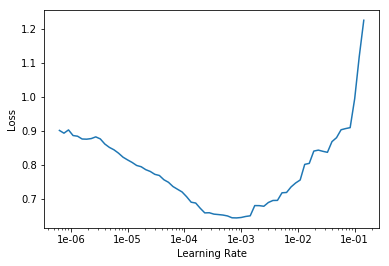

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(2, 2e-5)

epoch,train_loss,valid_loss,accuracy,time
0,0.544192,0.338155,0.856250,00:35
1,0.366021,0.335395,0.859375,00:35


In [0]:
def dumb_series_prediction(n):
  preds = []
  for loc in range(n):
    preds.append(int(learn.predict(test.iloc[loc]['comment'])[1]))
  return preds

In [0]:
preds = dumb_series_prediction(len(test))

In [0]:
preds[:10]

[1, 0, 1, 1, 1, 0, 1, 1, 1, 1]

In [0]:
from sklearn.metrics import classification_report, confusion_matrix

In [0]:
print(classification_report(test.sentiment, preds))

              precision    recall  f1-score   support

           0       0.89      0.85      0.87       203
           1       0.85      0.89      0.87       197

    accuracy                           0.87       400
   macro avg       0.87      0.87      0.87       400
weighted avg       0.87      0.87      0.87       400



In [0]:
print(confusion_matrix(test.sentiment, preds))

[[172  31]
 [ 22 175]]


In [0]:
pdata=learn.predict("设施老化，紧靠马路噪音太大，晚上楼上卫生间的水流声和空调噪音非常大，无法入眠")

In [0]:
print(pdata)

(Category 0, tensor(0), tensor([0.8321, 0.1679]))


In [0]:
label_denotation = {1:'正向评论',0:'负向评论'}

In [0]:
#标签涵义：1代表正向评论，0代表负向评论
print(label_denotation[int(pdata[1])])

负向评论
